#### Script to compute conditionally averaged variables.

James Ruppert  
jruppert@ou.edu  
7/15/23

In [1]:
from netCDF4 import Dataset
import numpy as np
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, rc
# import cartopy
from scipy import stats
import sys
import os
import pandas as pd
from precip_class import precip_class
from cfads_functions import mask_edges
from thermo_functions import esat, mixr_from_e
from write_ncfile import write_ncfile

In [2]:
# #### Main settings

# NOTE: Using copied tracking from CTL for NCRF tests

storm = 'haiyan'
# storm = 'maria'

# How many members
nmem = 10 # number of ensemble members
# nmem = 2

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/time_series/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

In [3]:
# Prep tests & ens members

def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

# Ens member strings
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

# Get pressure
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
varfil_main = Dataset(datdir+'post/d02/T.nc')
pres = varfil_main.variables['pres'][...]
pres = pres.data
varfil_main.close()
nz=pres.shape[0]
dp = (pres[0]-pres[1])*1e2 # Pa

# WRFOUT file list
path = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
dirlist = os.listdir(path)
subs="wrfout_d02"
wrf_files = list(filter(lambda x: subs in x, dirlist))
wrf_files.sort()
wrf_files = [path + s for s in wrf_files]
wrfout1 = wrf_files[0]

# Get Lat/Lon
ncfile = Dataset(wrfout1)
lon = ncfile.variables['XLONG'][0,0,:]
lat = ncfile.variables['XLAT'][0,:,0]
ncfile.close()
nx1 = lat.shape[0]
nx2 = lon.shape[0]

nt = np.zeros(ntest, dtype=np.int32)
for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()
    nt[itest]=i_nt

In [4]:
# Function to account for crossing of the Intl Date Line
def dateline_lon_shift(lon_in, reverse):
    if reverse == 0:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in < 0)] += 360
    else:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in > 180)] -= 360
    # return lon_in + lon_offset
    return lon_offset

def get_lon_offset_plt():
    # Check for crossing Date Line
    if (lon.min() < 0) and (lon.max() > 0):
        offset = 180
        lon_offset = dateline_lon_shift(lon, reverse=0)
    else:
        offset = 0
        lon_offset = 0
        clon_offset = 0
    lon_offset_plt = lon + lon_offset
    lon_offset_plt -= offset
    return offset, lon_offset_plt

offset, lon_offset_plt = get_lon_offset_plt()

---
#### Variable read and processing functions

In [5]:
def tidy_up(var):
    var = np.squeeze(var)
    var = np.ma.masked_invalid(var, copy=False)
    var = mask_edges(var)
    # Can swap in masking by TC track here
    var = np.ma.filled(var, fill_value=np.nan) # Abandon masking, replace mask with NaNs
    return var

def read_var(datdir, varname):
    readfile = Dataset(datdir+varname+'.nc')
    var = readfile.variables[varname][...]
    readfile.close()
    var = tidy_up(var)
    return var

def qvar_read(datdir):
    qfile = Dataset(datdir+'q_int.nc')
    q_int = qfile.variables['q_int'][...]
    qfile.close()
    q_int = tidy_up(q_int)
    return q_int

def read_qrain(datdir):
    readfile = Dataset(datdir+'QRAIN.nc')
    var = readfile.variables['QRAIN'][:,0,:,:]
    readfile.close()
    var = tidy_up(var)
    return var

def read_msevar(datdir):
    readfile = Dataset(datdir+'mse_diag.nc')
    vmfu = readfile.variables['vmfu'][...]
    vmfd = readfile.variables['vmfd'][...]
    mse = readfile.variables['mse_vint'][...]
    condh = readfile.variables['condh'][...] # K*kg/m2/s
    readfile.close()
    vmfu = tidy_up(vmfu)
    vmfd = tidy_up(vmfd)
    mse  = tidy_up(mse)
    condh  = tidy_up(condh)
    cp = 1004. # J/K/kg
    condh *= cp # Converts from above to W/m2
    return vmfu, vmfd, mse, condh

def read_lw_terms(datdir):
    # Vertically integrated radiative terms
    lw_t = read_var(datdir,'LWUPT') - read_var(datdir,'LWDNT') # W/m2
    lw_b = read_var(datdir,'LWUPB') - read_var(datdir,'LWDNB') # W/m2
    lw_net = lw_b - lw_t
    # Clear sky
    lw_tc = read_var(datdir,'LWUPTC') - read_var(datdir,'LWDNTC') # W/m2
    lw_bc = read_var(datdir,'LWUPBC') - read_var(datdir,'LWDNBC') # W/m2 = J/m2/s
    lw_net_cs = lw_bc - lw_tc
    lw_acre = lw_net - lw_net_cs
    # Direct read from file
    # readfile = Dataset(datdir+'LWacre.nc')
    # acre = readfile.variables['LWUPB'][...]
    # readfile.close()
    # acre = tidy_up(acre)
    lw_net = tidy_up(lw_net)
    lw_net_cs = tidy_up(lw_net_cs)
    return lw_net, lw_net_cs, lw_acre

# def read_buoy(datdir):
#     readfile = Dataset(datdir+filename_out)
#     buoy = readfile.variables['buoy'][...]
#     buoy_avg = readfile.variables['buoy_avg'][...]
#     readfile.close()
#     return buoy, buoy_avg

In [6]:
def calc_mse_budget(mse, lw_net, lw_net_cs):
    # Remove means
    mse_mean   = np.nanmean(mse, axis=(1,2))
    lw_mean    = np.nanmean(lw_net, axis=(1,2))
    lw_mean_cs = np.nanmean(lw_net_cs, axis=(1,2))
    mse_p   = mse -       mse_mean[:, np.newaxis, np.newaxis]
    lw_p    = lw_net -    lw_mean[:, np.newaxis, np.newaxis]
    lw_p_cs = lw_net_cs - lw_mean_cs[:, np.newaxis, np.newaxis]

    # Calculate covariance
    lwmse = mse_p*lw_p # J/m2 * J/m2/s = (J/m2)^2 / s
    msevar = np.nanvar(mse, axis=(1,2)) # (J/m2)^2
    lwmse /= msevar[:, np.newaxis, np.newaxis] # units = /s
    lwmse *= 3600*24 # /s --> /day

    # Clear-sky
    lwmse_cs = mse_p*lw_p_cs # J/m2 * J/m2/s = (J/m2)^2 / s
    lwmse_cs /= msevar[:, np.newaxis, np.newaxis] # units = /s
    lwmse_cs *= 3600*24 # s/day * /s = /day

    return lwmse, lwmse_cs, msevar

In [7]:
##### Conditional averaging (and weighting) ######################################

def get_condavg_settings():
    
    condavg_label = [
        'all',      # All unmasked points
        # 'non-precip',
        'deep',
        'cong',
        'shall',
        'strat',
        'anvil',
        'deepcong', # deep + cong
        'dpcgsh',   # deep + cong + shallow
        'stratanv', # strat + anv
        'allrain',  # deep + cong + strat + anv
        'upward',   # upward-motion-weighted
        'downward', # downward-motion-weighted
        ]

    condavg_title = [
        'All',
        # 'Non Precip',
        'Dc',
        'Cg',
        'Sh',
        'St',
        'An',
        'Dc+Cg',
        'Dc+Cg+Sh'
        'St+An',  
        'Dp+Cg+St+An',
        'Upward',
        'Downward',
        ]

    return condavg_label, condavg_title

condavg_label, condavg_title = get_condavg_settings()
ncond = len(condavg_label)

def conditional_avg(strat, vmfu, vmfd, var_stack):
# def conditional_avg(strat, vmfu, vmfd, invar):
    # Code modified from time_series_condavg.ipynb

    condavg_label, condavg_title = get_condavg_settings()
    ncond = len(condavg_label)
    shape = var_stack.shape
    nvar = shape[0]
    nt = shape[1]
    # nxy = shape[2]*shape[3]
    nxy = np.count_nonzero(~np.isnan(strat[0,...]))

    var_avg = np.zeros((ncond, nvar, nt))
    strat_frac = np.zeros((ncond, nt))

    # Internal functions
    def mask_mean(var_stack, condition):
        return np.nanmean(var_stack, axis=(2,3), where=condition)
    def get_strat_frac(condition, nxy):
        return np.count_nonzero(condition[0, ...], axis=(1,2)) / nxy
    def weighted_avg(var_stack, weights):
        num   = np.nansum(var_stack * weights, axis=(2,3))
        denom = np.nansum(weights,             axis=(2,3))
        return num/denom

    # Extend strat along a new dimension representing all variables to avoid loops in this task
    strat_extend = np.repeat(strat[np.newaxis, ...], nvar, axis=0)

    kcond=0
    # all = simple average over whole domain
    var_avg[kcond, ...] = np.nanmean(var_stack, axis=(2,3))
    strat_frac[kcond, :]= 1.

    for istrat in range(1,6):
        kcond+=1
        condition = (strat_extend == istrat)
        var_avg[kcond, ...] = mask_mean(var_stack, condition)
        strat_frac[kcond, :]= get_strat_frac(condition, nxy)

    kcond+=1
    # deep + cong
    condition = ((strat_extend == 1) | (strat_extend == 2))
    var_avg[kcond, ...] = mask_mean(var_stack, condition)
    strat_frac[kcond, :]= get_strat_frac(condition, nxy)

    kcond+=1
    # deep + cong + shallow
    condition = ((strat_extend == 1) | (strat_extend == 2) | (strat_extend == 3))
    var_avg[kcond, ...] = mask_mean(var_stack, condition)
    strat_frac[kcond, :]= get_strat_frac(condition, nxy)

    kcond+=1
    # strat + anv
    condition = ((strat_extend == 4) | (strat_extend == 5))
    var_avg[kcond, ...] = mask_mean(var_stack, condition)
    strat_frac[kcond, :]= get_strat_frac(condition, nxy)

    kcond+=1
    # allrain: deep + cong + strat + anv
    condition = ((strat_extend == 1) | (strat_extend == 2) | (strat_extend == 4) | (strat_extend == 5))
    var_avg[kcond, ...] = mask_mean(var_stack, condition)
    strat_frac[kcond, :]= get_strat_frac(condition, nxy)

    # Weighting function

    kcond+=1
    # upward-weighted
    vmfu_extend = np.repeat(vmfu[np.newaxis, ...], nvar, axis=0)
    var_avg[kcond, ...] = weighted_avg(var_stack, weights=vmfu_extend)
    strat_frac[kcond, :]= np.nan

    kcond+=1
    # downward-weighted
    vmfd_extend = np.repeat(vmfd[np.newaxis, ...], nvar, axis=0)
    var_avg[kcond, ...] = weighted_avg(var_stack, weights=vmfd_extend)
    strat_frac[kcond, :]= np.nan

    return var_avg, strat_frac

---
#### Loop over tests and ensemble members, reads and processes variables via the functions above.

In [8]:
# Create arrays

# Time index set based on TEST 0 (e.g., CTL)

# Raw fields for maps
# shape = (ntest,nmem,nt[0],nx1,nx2)
# lwmse_nx_sav = np.full(shape, np.nan, dtype=np.float64)
# lwmse_nx_cs_sav = np.full(shape, np.nan, dtype=np.float64)

# Only full-domain average
shape = (ntest,nmem,nt[0])
msevar_sav = np.full(shape, np.nan, dtype=np.float64)

# Conditionally averaged fields
shape = (ntest,nmem,ncond,nt[0])
stratfrac_sav = np.full(shape, np.nan, dtype=np.float64)
lwmse_sav = np.full(shape, np.nan, dtype=np.float64)
lwmse_cs_sav = np.full(shape, np.nan, dtype=np.float64)
condh_sav = np.full(shape, np.nan, dtype=np.float64)
lw_acre_sav = np.full(shape, np.nan, dtype=np.float64)
qrain_sav = np.full(shape, np.nan, dtype=np.float64)

# For NetCDF read/write
# dims_set_in=(nt[itest], ncond, nx1, nx2)
# var_names, descriptions, units, dim_names, dims_set = var_ncdf_metadata(dims_set_in)

#### Main loops

# icalculate = True # Set to false if calculations are done and just need to read in
# icalculate = False

for itest in range(ntest):
# for itest in range(1):

    print()
    print('Running test: ',tests[itest])
    print()

    tshift = get_tshift(tests[itest])
    times_itest = np.arange(tshift, nt[itest]+tshift, 1)

    for imemb in range(nmem):
#     for imemb in range(7,nmem):
#     for imemb in range(1):

        print('Running imemb: ',memb_all[imemb])
        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'

        # Read variables

        q_int = qvar_read(datdir) # mm
        strat = precip_class(q_int)
        strat = tidy_up(strat)
        vmfu, vmfd, mse, condh = read_msevar(datdir)
        lw_net, lw_net_cs, lw_acre = read_lw_terms(datdir)
        qrain = read_qrain(datdir)

############# MSE variance budget calculations ##############################

        # MSE budget terms
        lwmse, lwmse_cs, msevar = calc_mse_budget(mse, lw_net, lw_net_cs)

        # Save raw results
        # lwmse_nx_sav[   itest, imemb, tshift:nt[itest]+tshift, ...] = lwmse[...]
        # lwmse_nx_cs_sav[itest, imemb, tshift:nt[itest]+tshift, ...] = lwmse_cs[...]

############# Conduct conditional averaging ##############################

        var_list=[]
        var_list.append(lwmse)
        var_list.append(lwmse_cs)
        var_list.append(condh)
        var_list.append(lw_acre)
        var_list.append(qrain)
        var_stack = np.stack(var_list, axis=0)

        var_avg, strat_frac = conditional_avg(strat, vmfu, vmfd, var_stack)

        # Save averaged results
        msevar_sav[  itest, imemb, tshift:nt[itest]+tshift] = msevar
        stratfrac_sav[itest,imemb, :, tshift:nt[itest]+tshift] = strat_frac
        lwmse_sav[   itest, imemb, :, tshift:nt[itest]+tshift] = var_avg[:,0,:]
        lwmse_cs_sav[itest, imemb, :, tshift:nt[itest]+tshift] = var_avg[:,1,:]
        condh_sav[   itest, imemb, :, tshift:nt[itest]+tshift] = var_avg[:,2,:]
        lw_acre_sav[ itest, imemb, :, tshift:nt[itest]+tshift] = var_avg[:,3,:]
        qrain_sav[   itest, imemb, :, tshift:nt[itest]+tshift] = var_avg[:,4,:]


Running test:  ctl

Running imemb:  memb_01


/tmp/ipykernel_21017/3928635238.py:59: RuntimeWarning: Mean of empty slice
  return np.nanmean(var_stack, axis=(2,3), where=condition)


Running imemb:  memb_02
Running imemb:  memb_03
Running imemb:  memb_04
Running imemb:  memb_05
Running imemb:  memb_06
Running imemb:  memb_07
Running imemb:  memb_08
Running imemb:  memb_09
Running imemb:  memb_10

Running test:  ncrf36h

Running imemb:  memb_01
Running imemb:  memb_02
Running imemb:  memb_03
Running imemb:  memb_04
Running imemb:  memb_05
Running imemb:  memb_06
Running imemb:  memb_07
Running imemb:  memb_08
Running imemb:  memb_09
Running imemb:  memb_10


---
#### Plotting routines

In [9]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

rc('font', **font)

In [10]:
# Confidence interval using T-test and assuming 95% significance
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    # n = len(a)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    num = stats.t.ppf((1 + confidence) / 2., n-1)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
conf_set=0.95 # Confidence interval to apply throughout

#### Maps

In [11]:
# for ivar in range(2):

#     itim = 40

#     if ivar == 0:
#         pltvar = lwmse_nx_sav[0,0,itim,...]
#         title = "$h'LW'$ (normalized)"
#     elif ivar == 1:
#         pltvar = lwmse_nx_cs_sav[0,0,itim,...]
#         # pltvar = lwmse[itim,...]
#         title = "$h'LW'$-CS (normalized)"

#     units = '/day'
#     clevs = np.arange(-1.,1.,0.02)

#     fig = plt.figure(figsize=(12,5))
#     proj = cartopy.crs.PlateCarree(central_longitude=offset)
#     fig.set_facecolor('white')

#     ax = fig.add_subplot(111,projection=proj)
#     plt.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='RdGy_r', extend='both', zorder=1)
#     cbar=plt.colorbar(shrink=0.85, fraction=0.03, pad=0.05)
#     cbar.set_label(units)
#     ax.set_title(title, size=18)
#     # ax.set_xlabel('[km]')
#     # ax.set_ylabel('[km]')
#     ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
#     ax.add_feature(cartopy.feature.COASTLINE)
#     ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
#                 dms=True, x_inline=False, y_inline=False)
#     plt.tight_layout()

#### Time series

##### Time series comparing tests

In [36]:
# Plot variable settings

def plot_var_settings():
    var_plot=[
        'msevar',
        'lwmse',
        'lwmse_c',
        'stratfrac',
        'PE',
        'radlh_ratio',
        ]
    return var_plot

def get_plot_var(figtag):
    if figtag == 'msevar':
        var0_ivar = msevar_sav[0, ...]
        var1_ivar = msevar_sav[1, ...]
        title_tag = "$\sigma^2_h$"
        ylabel = '(J/m$^2$)$^2$'
    elif figtag == 'lwmse':
        var0_ivar = lwmse_sav[0, ...]
        var1_ivar = lwmse_sav[1, ...]
        title_tag = "$\overline{h'LW'}$"
        ylabel = '/day'
    elif figtag == 'lwmse_c':
        var0_ivar = lwmse_cs_sav[0, ...]
        var1_ivar = lwmse_cs_sav[1, ...]
        title_tag = "$\overline{h'LW'}$ (CS)"
        ylabel = '/day'
    elif figtag == 'stratfrac':
        var0_ivar = stratfrac_sav[0, ...]
        var1_ivar = stratfrac_sav[1, ...]
        title_tag = "Fractional Coverage"
        ylabel = '%'
    elif figtag == 'PE':
        var0_ivar = qrain_sav[0, ...] / np.abs(condh_sav[0, ...]) # /(mm/day)
        var1_ivar = qrain_sav[1, ...] / np.abs(condh_sav[1, ...]) # /(mm/day)
        var0_ivar *= 24 # /(mm/day) --> /(mm/hr)
        var1_ivar *= 24
        title_tag = "Rain / LH"
        ylabel = '/(W/m$^2$)'
    elif figtag == 'radlh_ratio':
        var0_ivar = np.abs(condh_sav[0, ...]) / np.abs(lw_acre_sav[0, ...])
        var1_ivar = np.abs(condh_sav[1, ...]) / np.abs(lw_acre_sav[1, ...])
        title_tag = "|LH/ACRE|"
        ylabel = '-'
    return var0_ivar, var1_ivar, title_tag, ylabel

all


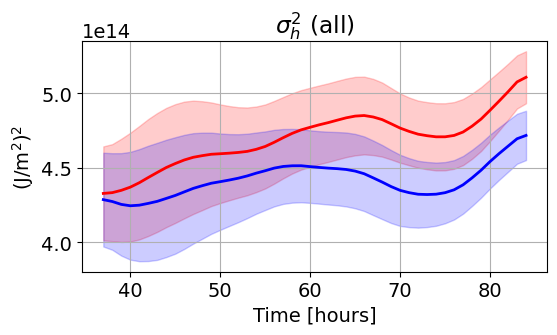

all


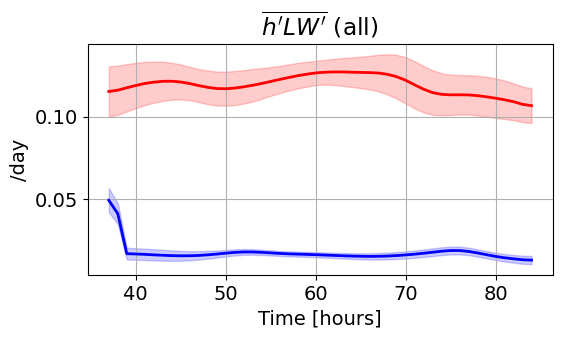

deep


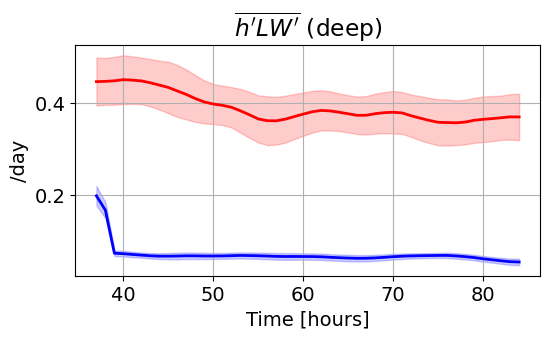

cong


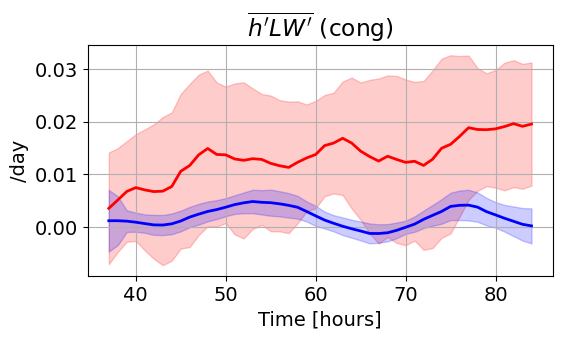

shall


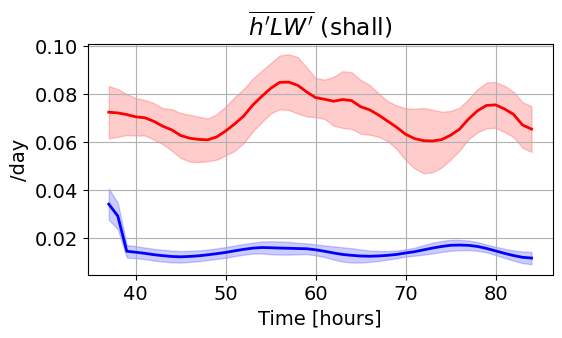

strat


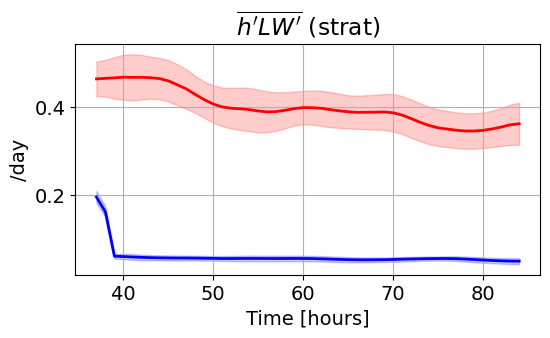

anvil


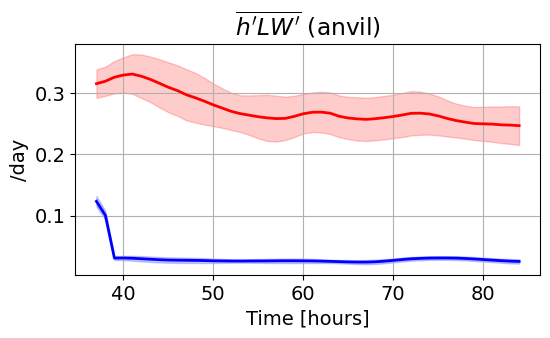

deepcong


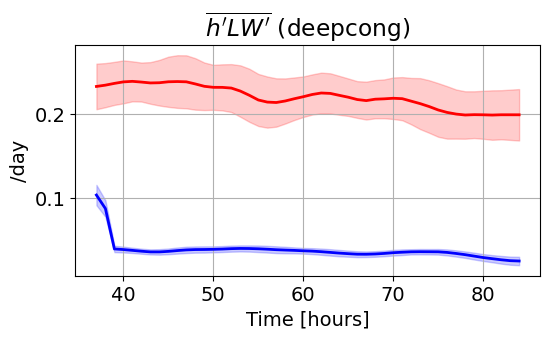

dpcgsh


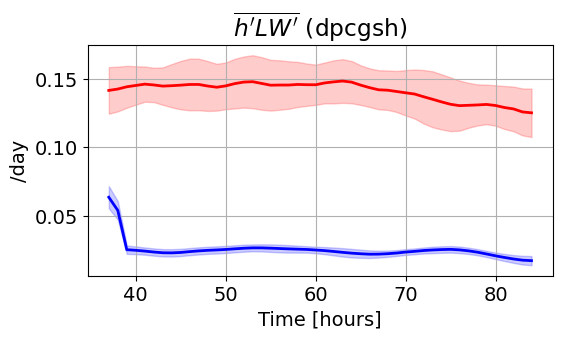

stratanv


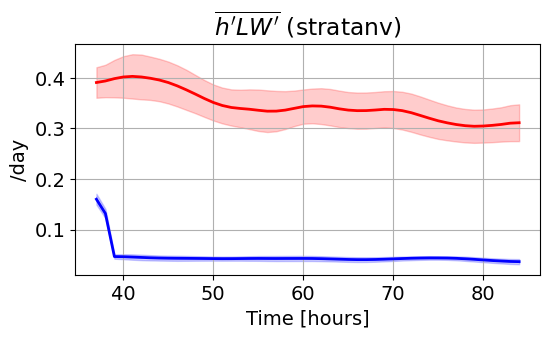

allrain


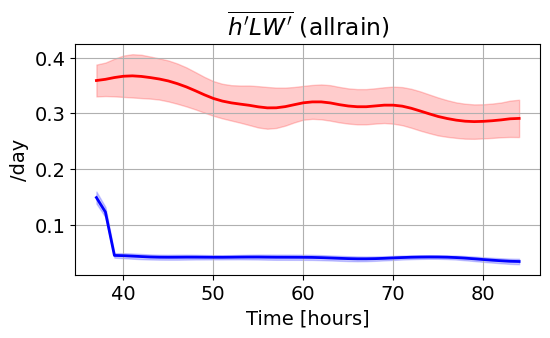

upward


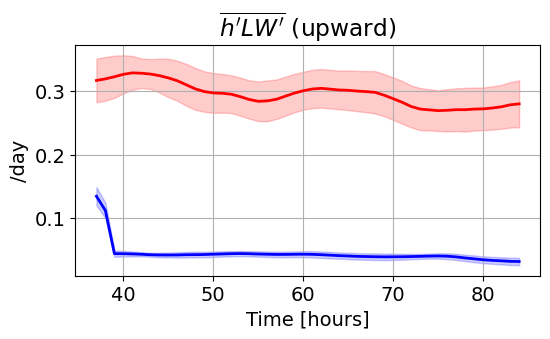

downward


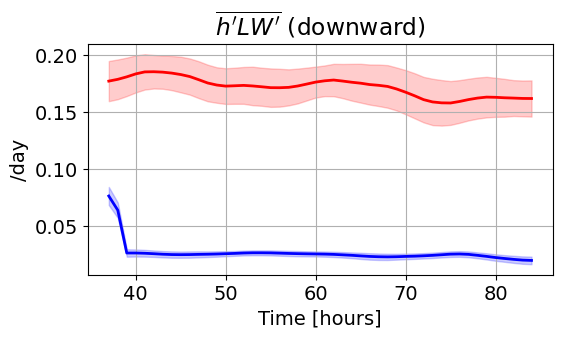

all


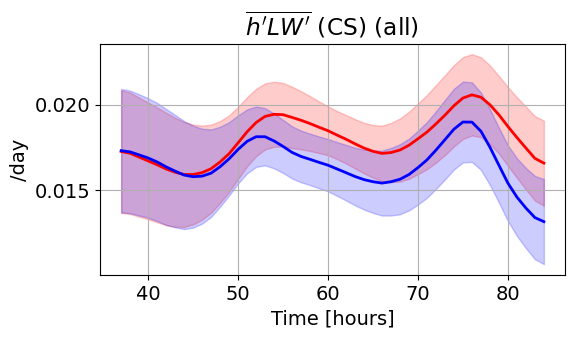

deep


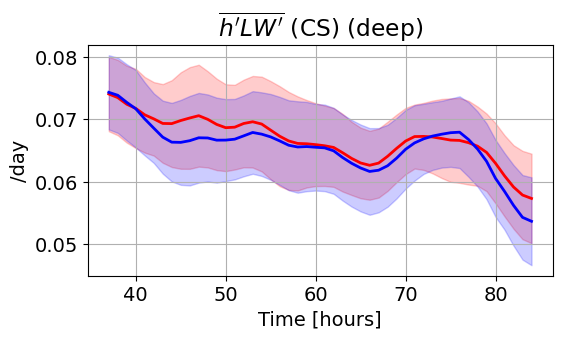

cong


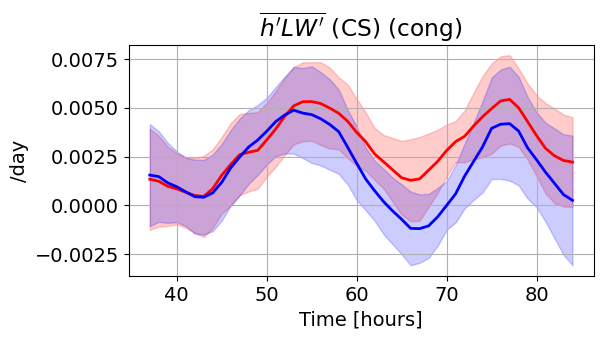

shall


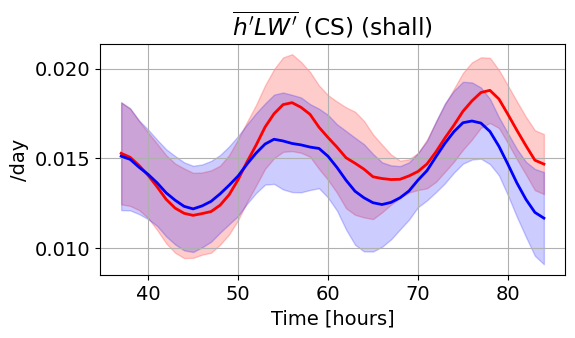

strat


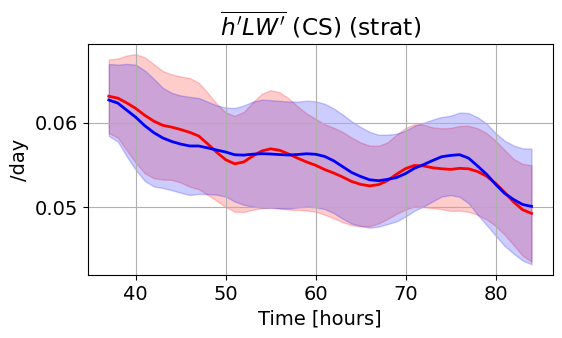

anvil


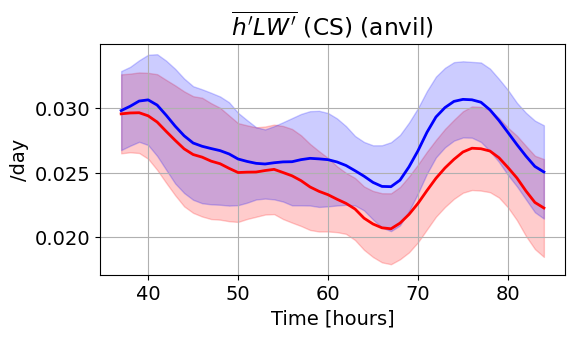

deepcong


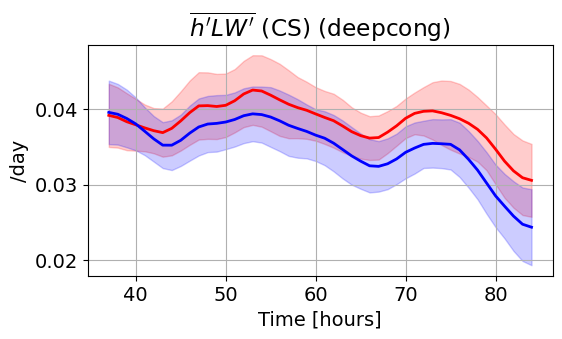

dpcgsh


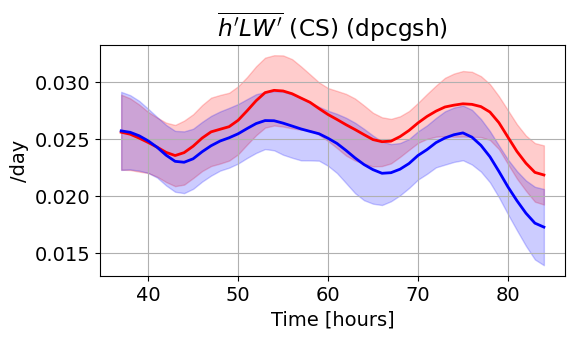

stratanv


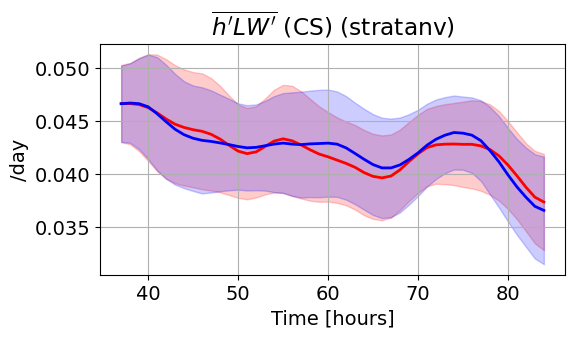

allrain


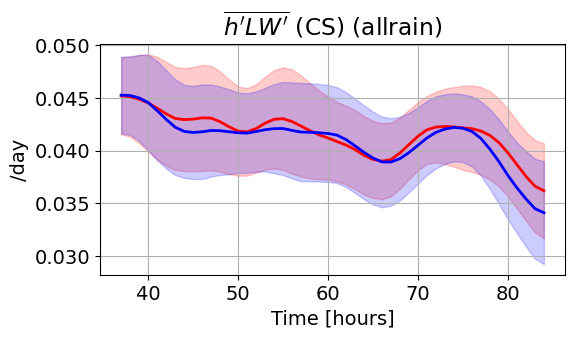

upward


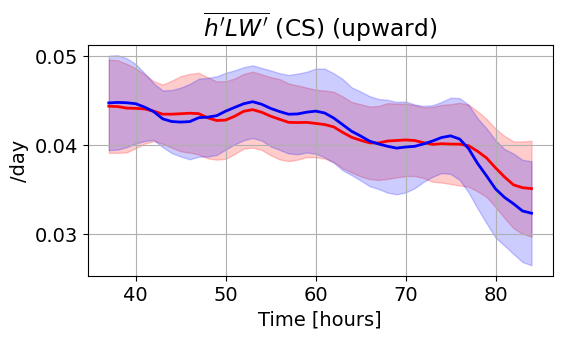

downward


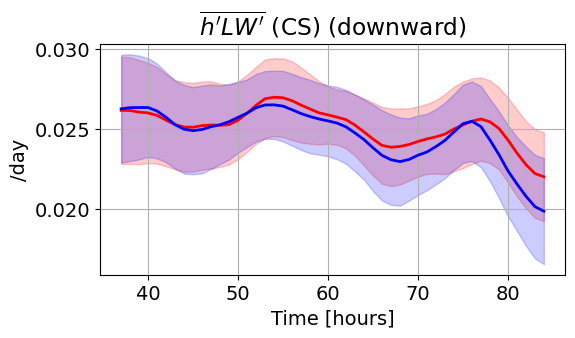

all


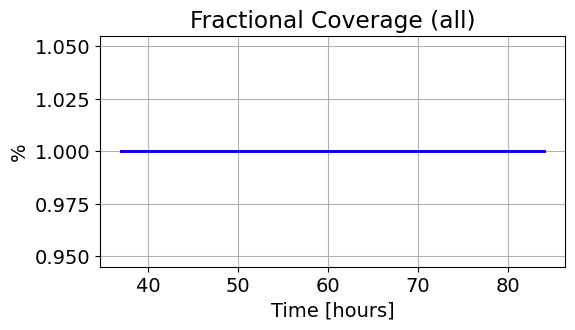

deep


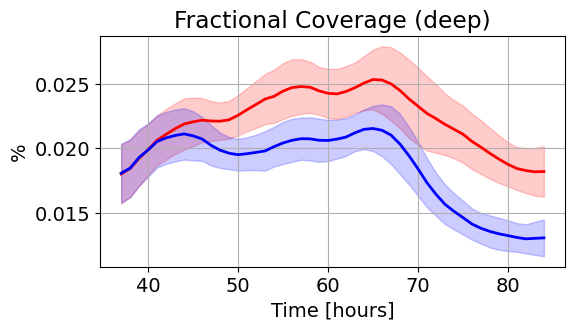

cong


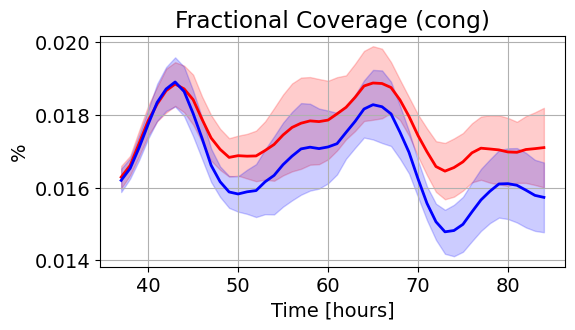

shall


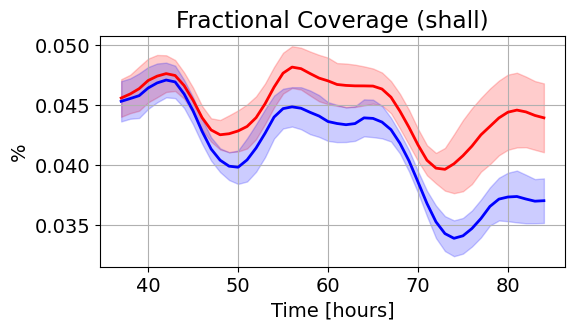

strat


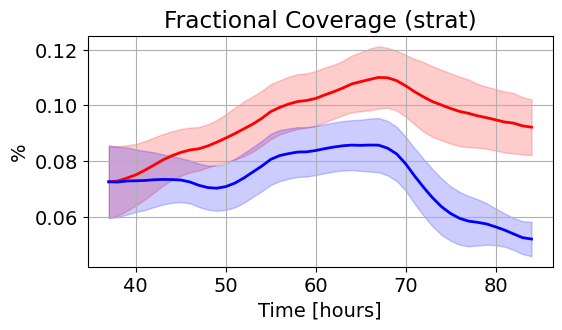

anvil


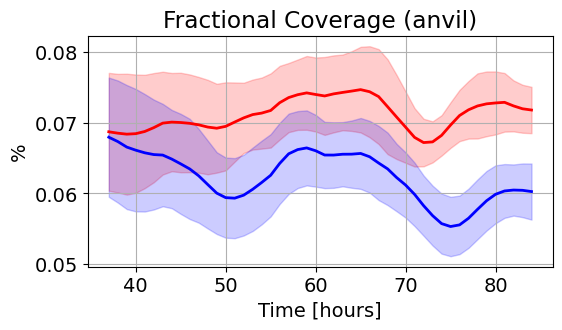

deepcong


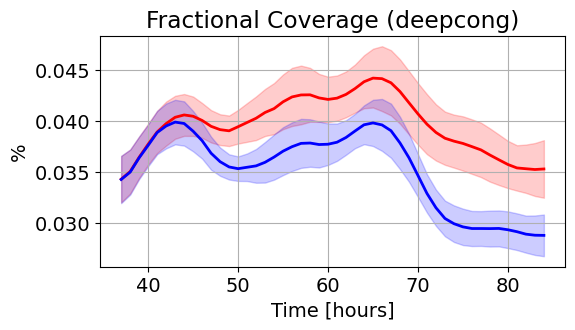

dpcgsh


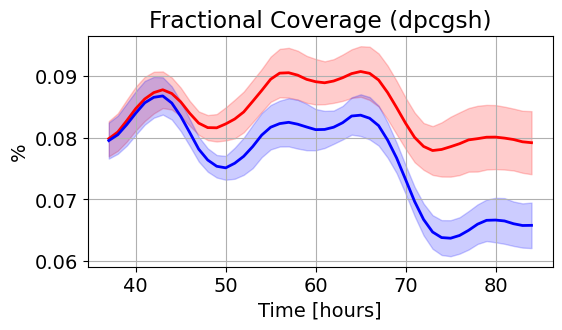

stratanv


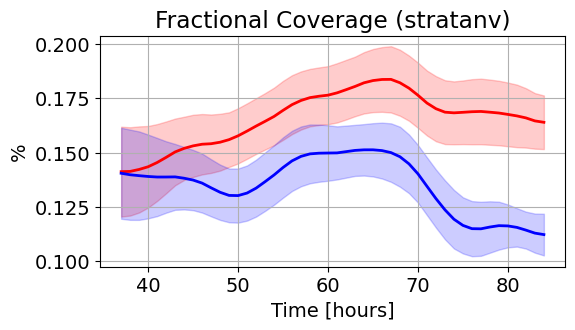

allrain


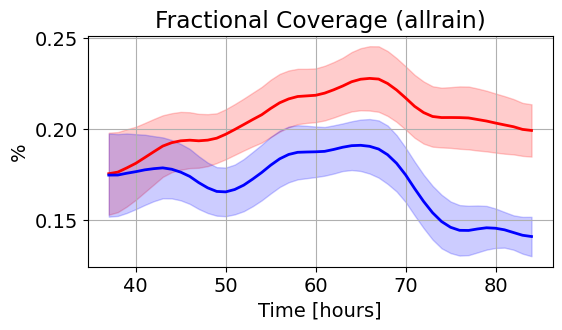

upward


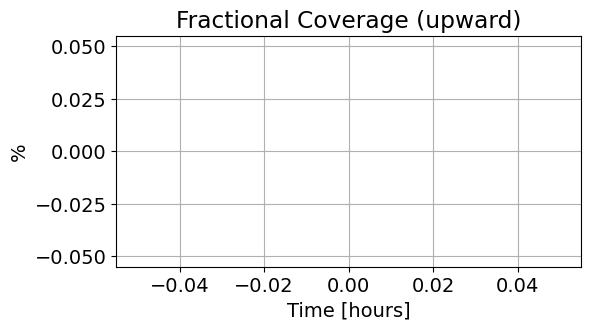

downward


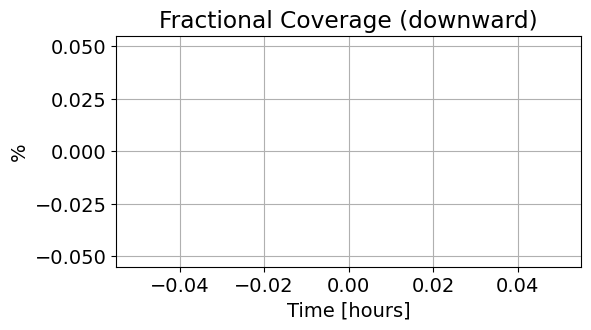

/tmp/ipykernel_21017/4033264899.py:36: RuntimeWarning: invalid value encountered in true_divide
  var0_ivar = qrain_sav[0, ...] / np.abs(condh_sav[0, ...]) # /(mm/day)


all


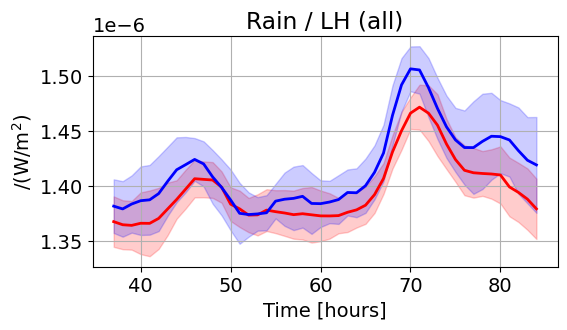

deep


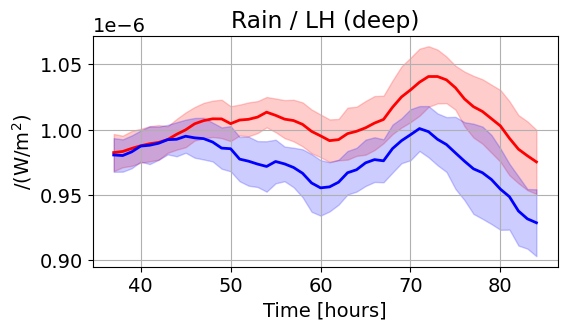

cong


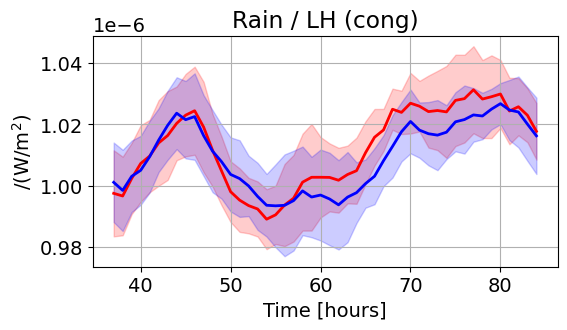

shall


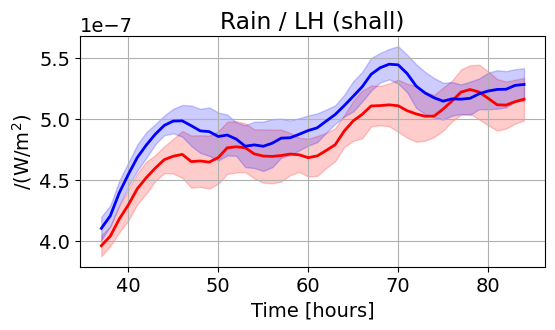

strat


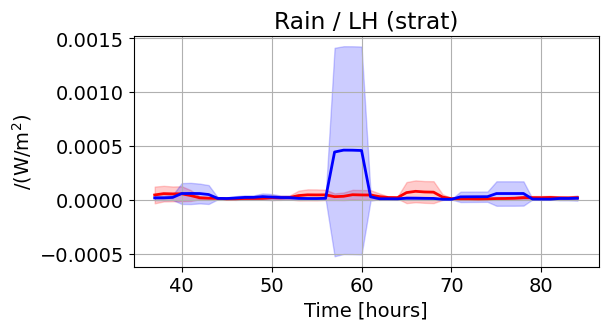

anvil


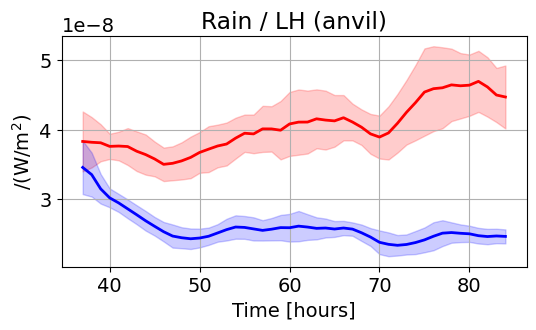

deepcong


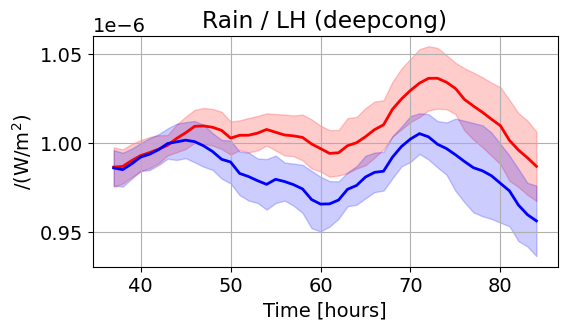

dpcgsh


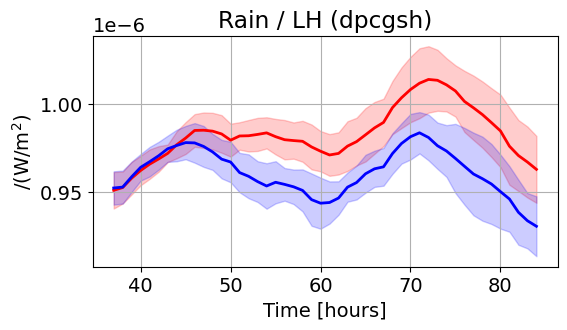

stratanv


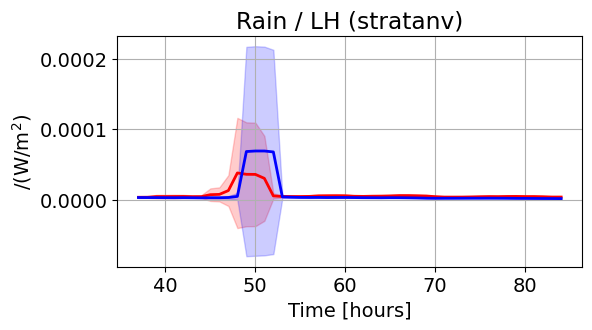

allrain


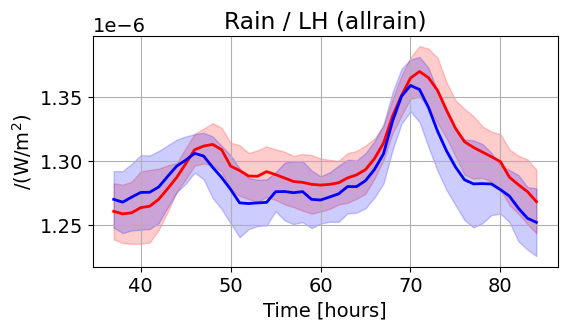

upward


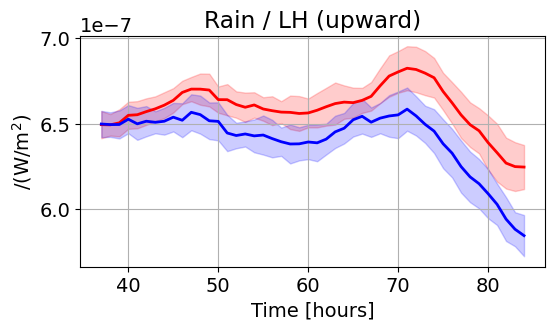

downward


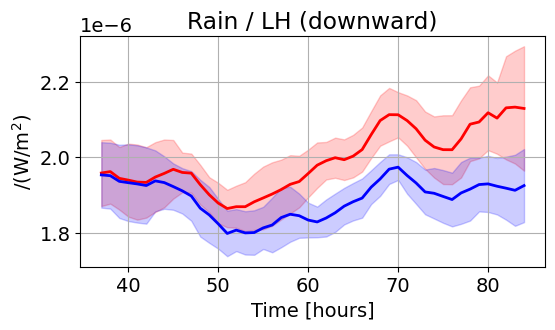

/tmp/ipykernel_21017/4033264899.py:43: RuntimeWarning: invalid value encountered in true_divide
  var0_ivar = np.abs(condh_sav[0, ...]) / np.abs(lw_acre_sav[0, ...])
/tmp/ipykernel_21017/4033264899.py:44: RuntimeWarning: divide by zero encountered in true_divide
  var1_ivar = np.abs(condh_sav[1, ...]) / np.abs(lw_acre_sav[1, ...])


all


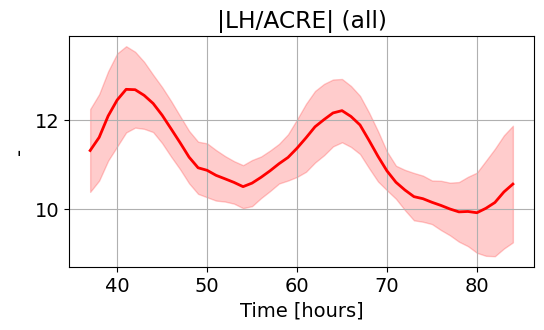

deep


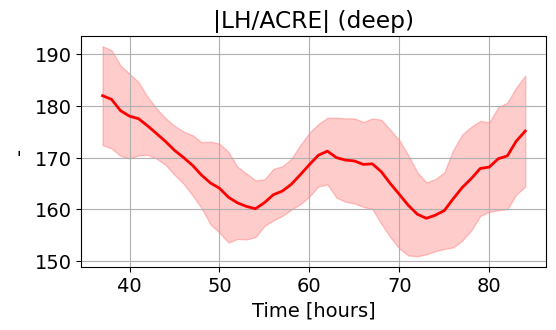

cong


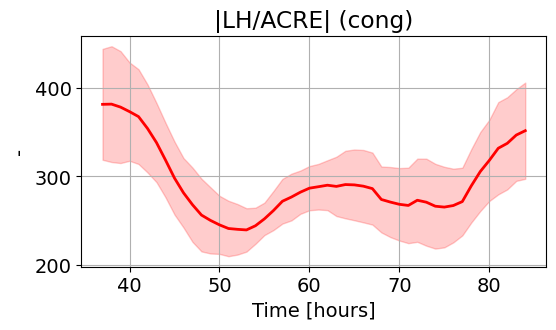

shall


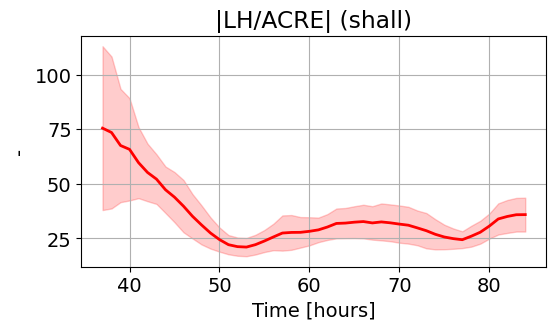

strat


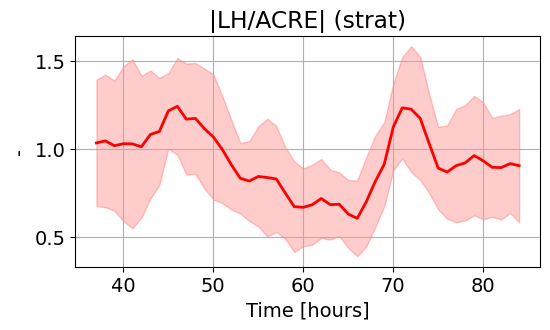

anvil


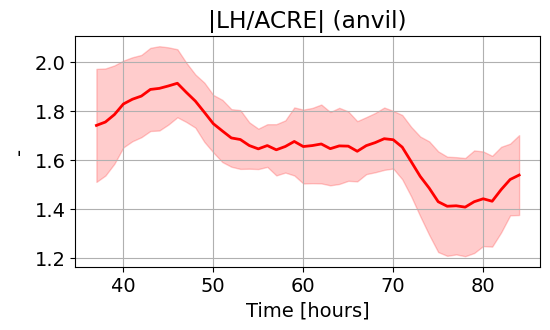

deepcong


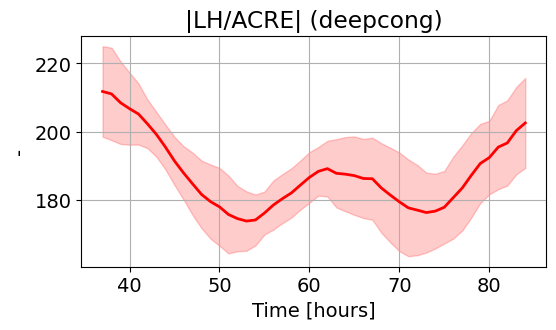

dpcgsh


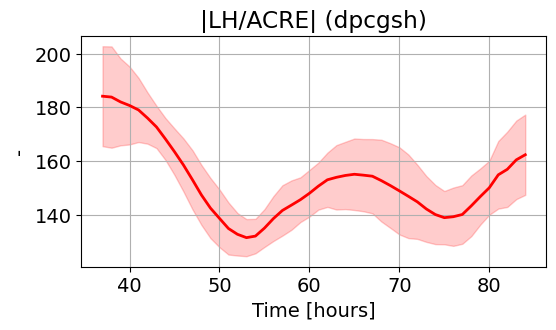

stratanv


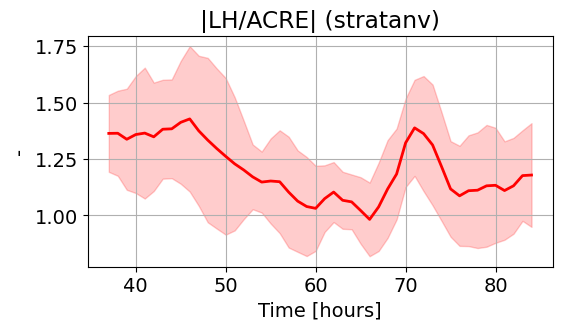

allrain


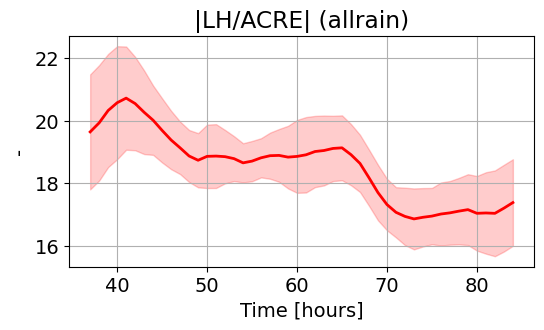

upward


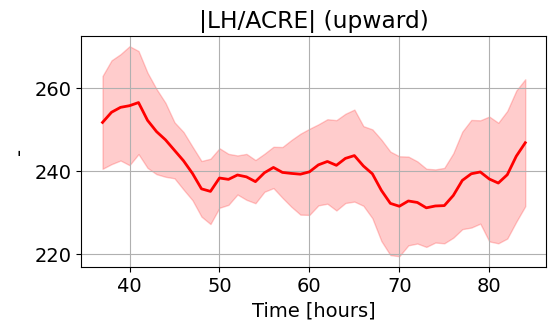

downward


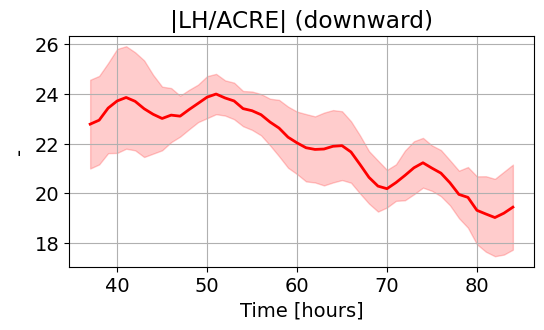

In [37]:
var_plot = plot_var_settings()
nvar_plot = len(var_plot)

times_ctl = np.arange(nt[0])

tshift = get_tshift(tests[1])
times_ncrf = np.arange(tshift, nt[1]+tshift, 1)

for ivar in range(nvar_plot):
# for ivar in range(1):

    figtag = var_plot[ivar]
    var0_ivar, var1_ivar, title_tag, ylabel = get_plot_var(figtag)

    for icond in range(ncond):

        if figtag == 'msevar':
            if (icond) > 0:
                continue
            var0 = np.copy(var0_ivar)
            var1 = np.copy(var1_ivar)
        else:
            var0 = np.copy(var0_ivar[:, icond, :])
            var1 = np.copy(var1_ivar[:, icond, :])

        var0 = var0[:,times_ncrf]
        var1 = var1[:,times_ncrf]

        fig_extra=condavg_label[icond]
        condtag=fig_extra #condavg_title[icond]
        print(fig_extra)

    #----------------------------------------------------------------

        # Use Pandas to smooth via running mean
        var0 = pd.DataFrame(var0)
        var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
        var1 = pd.DataFrame(var1)
        var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()

        # create figure
        fig = plt.figure(figsize=(6,3))
        ax = fig.add_subplot(111)

        ax.set_title(title_tag+' ('+condtag+')')#, fontsize=20)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Time [hours]')

        t_range=[times_ncrf[0], times_ncrf[-1]]
        # plt.xlim(t_range)

        color_t0 = 'red'
        color_t1 = 'blue'

        # xdim = times_ctl
        xdim = times_ncrf

        # Test 0

        # mean_t0 = np.nanmean(var0, axis=0)
        # std_t0 = np.nanstd(var0, axis=0)
        mean, low, high = mean_confidence_interval(var0, confidence=conf_set)

        plt.fill_between(xdim, high, low, alpha=0.2, color=color_t0)
        plt.plot(xdim, mean, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
        # plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

        # Test 1

        # mean_t1 = np.nanmean(var1, axis=0)
        # std_t1 = np.nanstd(var1, axis=0)
        mean, low, high = mean_confidence_interval(var1, confidence=conf_set)
        
        plt.fill_between(xdim, high, low, alpha=0.2, color=color_t1)
        plt.plot(xdim, mean, linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
        # plt.fill_between(xdim, mean_t1 + std_t1, mean_t1 - std_t1, alpha=0.2, color=color_t1)

        plt.grid()

        # plt.legend(loc="upper right")

        figdir2 = figdir+'all/'
        figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
        plt.savefig(figname,dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()

##### Time series comparing condavg categories

In [38]:
# Plot variable settings

def plot_var_settings():
    var_plot=[
        'lwmse',
        'lwmse2',
        'radlh_ratio',
        ]
    return var_plot

# shape = (ntest,nmem,ncond,nt[0])
icond_dc=1 # condavg index of Deep Con
icond_st=4 # condavg index of Strat
icond_an=5 # condavg index of Anvil
# icond_dccg=6 # condavg index of Deep Con + Congestus
icond_dccg=7 # condavg index of Deep Con + Congestus + Shallow
icond_stan=8 # condavg index of Strat + Anvil

def get_plot_var(figtag):
    if figtag == 'lwmse':
        var0_ivar = lwmse_sav[0, :, icond_dccg, :]
        var1_ivar = lwmse_sav[0, :, icond_stan, :]
        # var0_ivar = lwmse_sav[0, :, icond_dc, :]
        # var1_ivar = lwmse_sav[0, :, icond_st, :]
        # var2_ivar = lwmse_sav[0, :, icond_an, :]
        # var2_ivar=np.copy(var1_ivar)
        title_tag = "$\overline{h'LW'}$ (per grid point)"
        ylabel = '/day'
        fig_extra = 'dccg_strat'
        labels=['DcCg', 'StAn','']
        # labels=['Deep', 'Strat', 'Anvil']
    elif figtag == 'lwmse2':
        var0_ivar = lwmse_sav[0, :, icond_dccg, :] * stratfrac_sav[0, :, icond_dccg, :]
        var1_ivar = lwmse_sav[0, :, icond_stan, :] * stratfrac_sav[0, :, icond_stan, :]
        # var0_ivar = lwmse_sav[0, :, icond_dc, :] * stratfrac_sav[0, :, icond_dc, :]
        # var1_ivar = lwmse_sav[0, :, icond_st, :] * stratfrac_sav[0, :, icond_st, :]
        # var2_ivar = lwmse_sav[0, :, icond_an, :] * stratfrac_sav[0, :, icond_an, :]
        # var2_ivar=np.copy(var1_ivar)
        title_tag = "$\overline{h'LW'}$"
        ylabel = '/day'
        fig_extra = 'dccg_strat'
        labels=['DcCg', 'StAn', '']
        # labels=['Deep', 'Strat', 'Anvil']
    elif figtag == 'radlh_ratio':
        # radlhratio = np.abs(lw_acre_sav) / np.abs(condh_sav)
        radlhratio = np.abs(condh_sav) / np.abs(lw_acre_sav)
        var0_ivar = radlhratio[0, :, icond_dccg, :]
        var1_ivar = radlhratio[0, :, icond_stan, :]
        # var0_ivar = radlhratio[0, :, icond_dc, :]
        # var1_ivar = radlhratio[0, :, icond_st, :]
        # var2_ivar = radlhratio[0, :, icond_an, :]
        # title_tag = "|ACRE/LH|"
        title_tag = "|LH/ACRE|"
        # ylabel = 'mm/day / W/m$^2$'
        ylabel = '-'
        fig_extra = 'dccg_strat'
        labels=['DeepCong', 'StratAnv','']
        # labels=['Deep', 'Strat', 'Anvil']
    var2_ivar = np.copy(var1_ivar)
    var2_ivar[:]=np.nan
    return var0_ivar, var1_ivar, var2_ivar, title_tag, ylabel, fig_extra, labels

/tmp/ipykernel_21017/2911454814.py:85: RuntimeWarning: Mean of empty slice
  mean_t2 = np.nanmean(var2, axis=0)
/home/jamesrup/miniconda3/envs/plotting/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


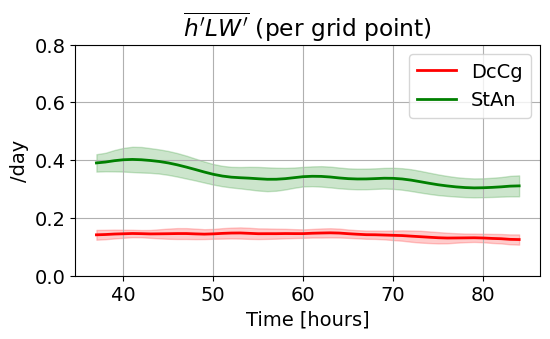

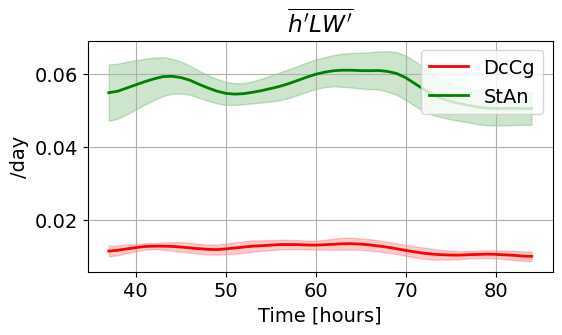

/tmp/ipykernel_21017/2817911899.py:46: RuntimeWarning: divide by zero encountered in true_divide
  radlhratio = np.abs(condh_sav) / np.abs(lw_acre_sav)
/tmp/ipykernel_21017/2817911899.py:46: RuntimeWarning: invalid value encountered in true_divide
  radlhratio = np.abs(condh_sav) / np.abs(lw_acre_sav)


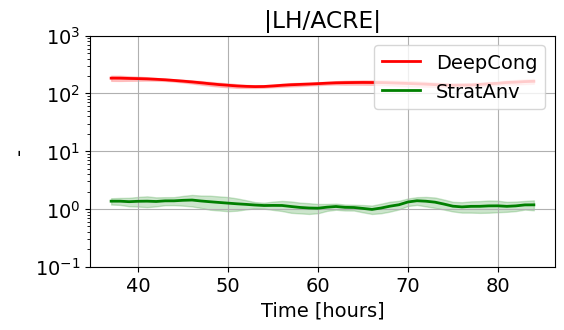

In [39]:
# Special cases comparing condavg categories

var_plot = plot_var_settings()
nvar_plot = len(var_plot)

times_ctl = np.arange(nt[0])

tshift = get_tshift(tests[1])
times_ncrf = np.arange(tshift, nt[1]+tshift, 1)

for ivar in range(nvar_plot):
# for ivar in range(1):

    figtag = var_plot[ivar]
    var0_ivar, var1_ivar, var2_ivar, title_tag, ylabel, fig_extra, labels = get_plot_var(figtag)

    var0 = np.copy(var0_ivar)
    var1 = np.copy(var1_ivar)
    var2 = np.copy(var2_ivar)
    var0 = var0[:,times_ncrf]
    var1 = var1[:,times_ncrf]
    var2 = var2[:,times_ncrf]

    # fig_extra=condavg_label[icond]
    # condtag=fig_extra #condavg_title[icond]
    # print(fig_extra)

#----------------------------------------------------------------

    # Use Pandas to smooth via running mean
    var0 = pd.DataFrame(var0)
    var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
    var1 = pd.DataFrame(var1)
    var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()

    # create figure
    fig = plt.figure(figsize=(6,3))
    ax = fig.add_subplot(111)

    ax.set_title(title_tag)#+' ('+condtag+')')#, fontsize=20)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Time [hours]')

    if figtag == 'lwmse':
        plt.yscale('linear')
        plt.ylim([0,0.8])
    elif figtag == 'radlh_ratio':
        plt.yscale('log')
        plt.ylim([1e-1,1e3])
        # plt.ylim([0,250])

    t_range=[times_ncrf[0], times_ncrf[-1]]
    # plt.xlim(t_range)

    color_t0 = 'red'
    color_t1 = 'green'
    color_t2 = 'blue'

    # xdim = times_ctl
    xdim = times_ncrf

    # Test 0

    # mean_t0 = np.nanmean(var0, axis=0)
    # std_t0 = np.nanstd(var0, axis=0)
    mean, low, high = mean_confidence_interval(var0, confidence=conf_set)

    plt.fill_between(xdim, high, low, alpha=0.2, color=color_t0)
    plt.plot(xdim, mean, linewidth=2, label=labels[0], color=color_t0, linestyle='solid')
    # plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

    # Test 1

    # mean_t1 = np.nanmean(var1, axis=0)
    # std_t1 = np.nanstd(var1, axis=0)
    mean, low, high = mean_confidence_interval(var1, confidence=conf_set)

    plt.fill_between(xdim, high, low, alpha=0.2, color=color_t1)
    plt.plot(xdim, mean, linewidth=2, label=labels[1], color=color_t1, linestyle='solid')
    # plt.fill_between(xdim, mean_t1 + std_t1, mean_t1 - std_t1, alpha=0.2, color=color_t1)

    # Test 2

    # if ivar == 1:
    mean_t2 = np.nanmean(var2, axis=0)
    std_t2 = np.nanstd(var2, axis=0)
    plt.plot(xdim, mean_t2, linewidth=2, label=labels[2], color=color_t2, linestyle='solid')
    plt.fill_between(xdim, mean_t2 + std_t2, mean_t2 - std_t2, alpha=0.2, color=color_t2)

    plt.grid()

    plt.legend(loc="upper right")

    figdir2 = figdir+'all/'
    # figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
    figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
    plt.savefig(figname,dpi=200, facecolor='white', \
                bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()

##### Time series showing the normalized change

In [40]:
# tshift = get_tshift(tests[itest])
# times_ncrf = np.arange(tshift, nt[itest]+tshift, 1)

# var0_ivar = lwmse_sav[0, ...]
# var1_ivar = lwmse_sav[1, ...]
# var0_ivar = var0_ivar[:, :, times_ncrf]
# var1_ivar = var1_ivar[:, :, times_ncrf]

# var_plot = (var0_ivar - var1_ivar) / var0_ivar

# figtag = 'lwmse-dnorm'
# ylabel = '-'
# title_tag = 'Normlized difference'

# for icond in range(ncond):

#     fig_extra=condavg_label[icond]
#     condtag=fig_extra #condavg_title[icond]
#     print(fig_extra)

#     var0 = np.copy(var_plot[:, icond, :])

# #----------------------------------------------------------------

#     # Use Pandas to smooth via running mean
#     var0 = pd.DataFrame(var0)
#     var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
#     var1 = pd.DataFrame(var1)
#     var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()

#     # create figure
#     fig = plt.figure(figsize=(6,3))
#     ax = fig.add_subplot(111)

#     ax.set_title(title_tag+' ('+condtag+')')#, fontsize=20)
#     ax.set_ylabel(ylabel)
#     ax.set_xlabel('Time [hours]')

#     t_range=[times_ncrf[0], times_ncrf[-1]]
#     # plt.xlim(t_range)

#     color_t0 = 'red'
#     color_t1 = 'blue'

#     # Test 0

#     mean_t0 = np.nanmean(var0, axis=0)
#     std_t0 = np.nanstd(var0, axis=0)

#     xdim = times_ncrf

#     plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
#     plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

#     plt.grid()

#     # plt.legend(loc="upper right")

#     figdir2 = figdir+'all/'
#     figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
#     plt.savefig(figname,dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
#     plt.show()
#     plt.close()